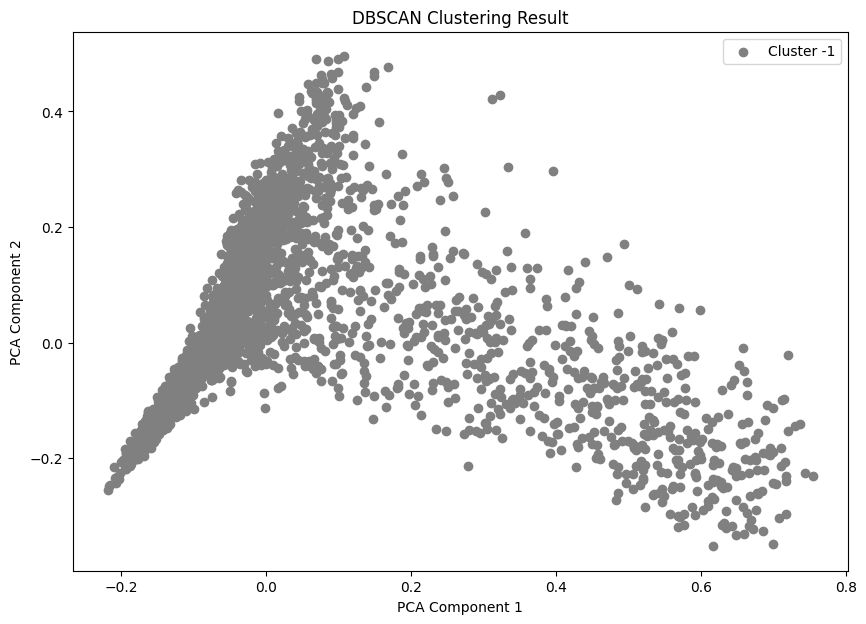

In [4]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

# 1. 피클 파일에서 Series 불러오기
with open('data/okt.pkl', 'rb') as f:
    normalized = pickle.load(f)

# 2. 불용어 읽어오기
stopwords_file_path = 'stopwords_dh_last.txt'
stopwords = []
with open(stopwords_file_path, 'r', encoding='utf-8') as file:
    stopwords = [line.strip() for line in file.readlines()]

# 3. 불용어 제거 및 LDA 적용
def remove_stopwords(text):
    tokens = text.split()  # 공백으로 나누기
    filtered_tokens = [word for word in tokens if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_tokens)  # 다시 문자열로 결합

normalized_cleaned = [remove_stopwords(' '.join([word for word in text.split() if word not in stopwords])
) for text in normalized]

# 4. TF-IDF 벡터라이저 적용
vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = vectorizer.fit_transform(normalized_cleaned)

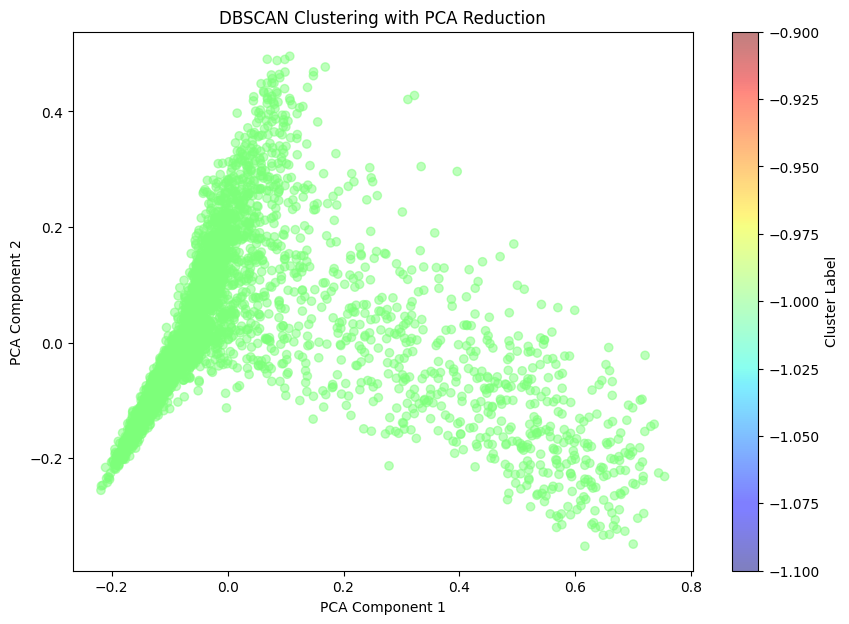

In [7]:
from sklearn.preprocessing import Normalizer

# 5. TF-IDF 행렬 정규화
normalizer = Normalizer()
tfidf_normalized = normalizer.fit_transform(tfidf_matrix)

# 6. DBSCAN 수행
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps와 min_samples는 하이퍼파라미터
clusters = dbscan.fit_predict(tfidf_normalized)

# 7. PCA로 2D로 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_normalized.toarray())

# 8. DBSCAN 결과에 따른 시각화
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='jet', alpha=0.5)
plt.title('DBSCAN Clustering with PCA Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

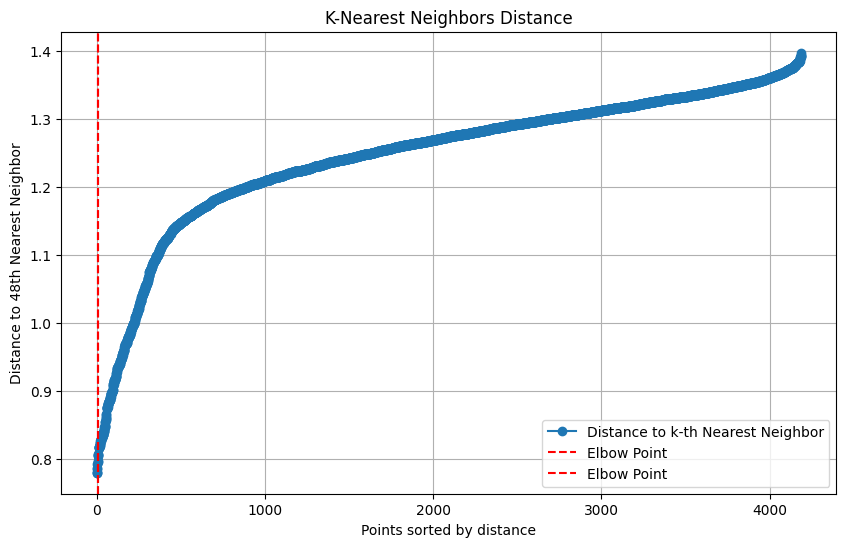

엘보우 포인트 인덱스: 11, 거리: 0.8070821807686881


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# TF-IDF 스케일링된 데이터
data = tfidf_normalized  # DBSCAN에 사용할 데이터

# KNN 거리 계산
k = 48  # k의 값, 일반적으로 min_samples와 같은 값으로 설정
nbrs = NearestNeighbors(n_neighbors=k).fit(data)
distances, indices = nbrs.kneighbors(data)

# k번째 이웃과의 거리 추출
distances = np.sort(distances[:, k-1], axis=0)

# 거리의 기울기 계산
distances_diff = np.diff(distances)  # 거리 변화량
slope = np.abs(np.diff(distances_diff))  # 변화량의 기울기

# 엘보우 포인트 찾기: 기울기가 가장 큰 인덱스
elbow_index = np.argmax(slope) + 1  # +1을 해주는 이유는 diff 연산으로 인해 길이가 하나 줄어들기 때문

# 거리 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(distances, label='Distance to k-th Nearest Neighbor', marker='o')
plt.axvline(x=elbow_index, color='r', linestyle='--', label='Elbow Point')
plt.title('K-Nearest Neighbors Distance')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th Nearest Neighbor')
plt.grid()
plt.axvline(x=elbow_index, color='red', linestyle='--', label='Elbow Point')
plt.legend()
plt.show()

# 엘보우 포인트 인덱스와 거리 값 출력
print(f'엘보우 포인트 인덱스: {elbow_index}, 거리: {distances[elbow_index]}')


In [20]:
elbow_index

11

클러스터 수: 6


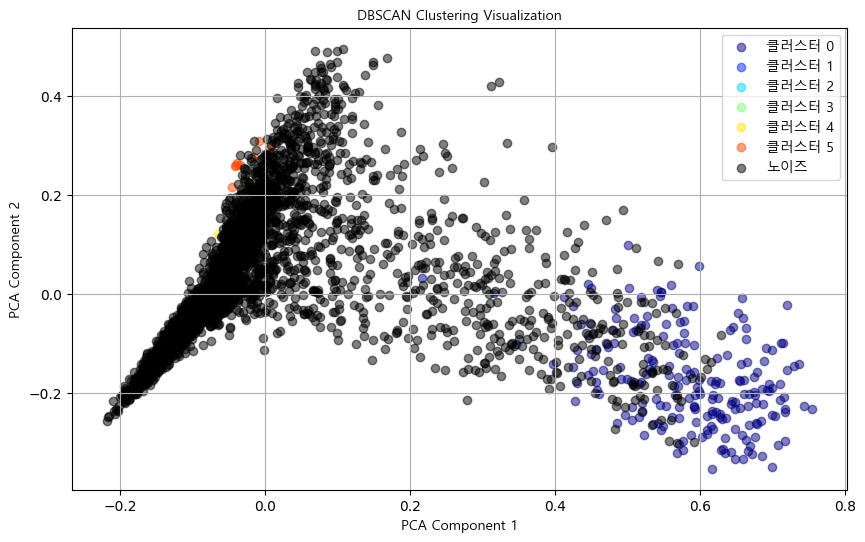

In [32]:
from sklearn.preprocessing import Normalizer
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 5. TF-IDF 행렬 정규화
normalizer = Normalizer()
tfidf_normalized = normalizer.fit_transform(tfidf_matrix)

# 6. DBSCAN 수행
dbscan = DBSCAN(eps=0.8070821807686881, min_samples=8)  # eps와 min_samples는 하이퍼파라미터
clusters = dbscan.fit_predict(tfidf_normalized)

# 7. PCA로 2D로 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_normalized.toarray())

# 클러스터 수 및 노이즈 포인트 확인
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # -1은 노이즈 포인트를 의미
print(f'클러스터 수: {num_clusters}')


# 한글 폰트 설정 (Windows에서의 Malgun Gothic)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 폰트 경로 설정
font_prop = font_manager.FontProperties(fname=font_path)


# 8. DBSCAN 결과에 따른 시각화
plt.figure(figsize=(10, 6))
unique_clusters = set(clusters)
colors = cm.jet(np.linspace(0, 1, len(unique_clusters)))  # 색상 맵 생성

# 클러스터별 레전드를 저장할 리스트
legend_labels = []

for cluster in unique_clusters:
    if cluster == -1:  # 노이즈 포인트는 검정색으로 표시
        color = 'black'
        label = '노이즈'
    else:
        color = colors[cluster % len(colors)]
        label = f'클러스터 {cluster}'
        legend_labels.append(label)  # 레전드에 클러스터 이름 추가

    # 클러스터에 해당하는 포인트를 시각화
    plt.scatter(pca_result[clusters == cluster, 0], pca_result[clusters == cluster, 1], 
                color=color, label=label, alpha=0.5)

# 레전드 중복 제거 및 한글 폰트 적용
plt.title('DBSCAN Clustering Visualization', fontproperties=font_prop)
plt.xlabel('PCA Component 1', fontproperties=font_prop)
plt.ylabel('PCA Component 2', fontproperties=font_prop)

# 중복된 레전드 항목을 제거하기 위해 set() 사용
handles, _ = plt.gca().get_legend_handles_labels()
by_label = dict(zip(_, handles))
plt.legend(by_label.values(), by_label.keys(), prop=font_prop)

plt.grid()
plt.show()

적절하게 클러스터링 되지 않는다.